<a href="https://colab.research.google.com/github/LokeshJatangi/EVA-vision/blob/master/Project%207/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D ,SeparableConv2D
from keras.layers.merge import concatenate
from keras.layers import Activation, Flatten, Input, Dropout,Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
np.random.seed(879) 

import tensorflow as tf

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)




Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


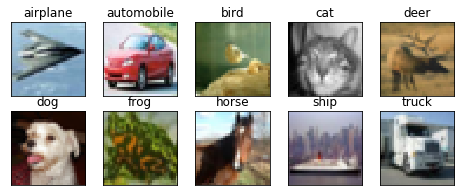

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')  
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# ENAS Network

In [0]:
# Define the model

inputs = Input(shape=(32,32 , 3), name = 'input_images')

# Depthwise Separable Convolution
layer_1 = SeparableConv2D(32 ,5,5, activation='relu',border_mode='same', name = 'DepthSep_01')(inputs)
layer_1 = BatchNormalization()(layer_1)

# Normal Convolution
layer_2  = Conv2D(32,5,5,activation='relu',border_mode='same',name='Norm_conv_02')(layer_1) 
layer_2= BatchNormalization()(layer_2)

# Normal Convolution
layer_3  = Conv2D(64,5,5,activation='relu',border_mode='same',name='Norm_conv_03')(layer_2) 
layer_3= BatchNormalization()(layer_3)

# Merging layer_1 and layer_3
merge_1 = concatenate([layer_1,layer_3],axis=-1)

# Depthwise Separable Convolution
layer_4 = SeparableConv2D(64 ,5,5, activation='relu',border_mode='same', name = 'DepthSep_04')(merge_1)
layer_4 = BatchNormalization()(layer_4)
layer_4 = Dropout(.4)(layer_4)

# Merging layer_1 and layer_4
merge_2 = concatenate([layer_1,layer_4],axis=-1)

#Max pooling
pooling_layer_1 = MaxPooling2D(pool_size=(2,2))(merge_2)
pooling_layer_1= BatchNormalization()(pooling_layer_1)

# Depthwise Separable Convolution
layer_5 = SeparableConv2D(64 ,3,3, activation='relu',border_mode='same', name = 'DepthSep_05')(pooling_layer_1)
layer_5 = BatchNormalization()(layer_5)

# Merging layer_1 , layer_4 and layer_5
merge_3 = concatenate([Lambda(space_to_depth_x2)(layer_1),Lambda(space_to_depth_x2)(layer_4),layer_5],axis=-1)

# Normal Convolution
layer_6  = Conv2D(128,5,5,activation='relu',border_mode='same',name='Norm_conv_06')(merge_3) 
layer_6= BatchNormalization()(layer_6)
layer_6 = Dropout(.5)(layer_6)

# Merging layer_5,layer_6,layer_4 and layer_3
merge_4 = concatenate([Lambda(space_to_depth_x2)(layer_4),Lambda(space_to_depth_x2)(layer_3),layer_6,layer_5],axis=-1)

# Depthwise Separable Convolution
layer_7 = SeparableConv2D(128 ,3,3, activation='relu',border_mode='same', name = 'DepthSep_07')(merge_4)
layer_7 = BatchNormalization()(layer_7)

# Merging layer_5,layer_6,layer_7,layer_1,layer_3,layer_4
merge_5 = concatenate([Lambda(space_to_depth_x2)(layer_4),Lambda(space_to_depth_x2)(layer_3),Lambda(space_to_depth_x2)(layer_1),layer_6,layer_5,layer_7],axis=-1)

# Depthwise Separable Convolution
layer_8 = SeparableConv2D(256 ,5,5, activation='relu',border_mode='same', name = 'DepthSep_08')(merge_5)
layer_8 = BatchNormalization()(layer_8)
layer_8 = Dropout(.4)(layer_8)

# Merging layer_8,layer_4,layer_5,layer_7,layer_1
merge_6 = concatenate([Lambda(space_to_depth_x2)(layer_4),Lambda(space_to_depth_x2)(layer_1),layer_8,layer_5,layer_7],axis=-1)

#Max pooling
pooling_layer_2 = MaxPooling2D(pool_size=(2,2))(merge_6)
pooling_layer_2= BatchNormalization()(pooling_layer_2)

# Merging Pooling_layer_2 and layer_6
merge_7 = concatenate([Lambda(space_to_depth_x2)(layer_6),pooling_layer_2],axis=-1)

# Normal Convolution
layer_9  = Conv2D(32,5,5,activation='relu',border_mode='same',name='Norm_conv_09')(merge_7) 
layer_9= BatchNormalization()(layer_9)

# Merging layer_2,layer_4,layer_7,layer_9
merge_8 = concatenate([Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_4)),Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_2)),Lambda(space_to_depth_x2)(layer_7),
                       layer_9],axis=-1)

# Depthwise Separable Convolution
layer_10 = SeparableConv2D(128 ,5,5, activation='relu',border_mode='same', name = 'DepthSep_10')(merge_8)
layer_10 = BatchNormalization()(layer_10)
layer_10 = Dropout(.4)(layer_10)

# Merging  layer_10,layer_9,layer_5,layer_2,layer_3 
merge_9 = concatenate([Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_3)),
                       Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_2)),
                       Lambda(space_to_depth_x2)(layer_5),layer_9,layer_10],axis=-1)

# Normal Convolution
layer_11  = Conv2D(256,3,3,activation='relu',border_mode='same',name='Norm_conv_11')(merge_9) 
layer_11= BatchNormalization()(layer_11)
layer_11 = Dropout(.3)(layer_11)

# Merging  layer_11,layer_10, layer_7,layer_5,layer_4,layer_3,layer_1
merge_10 = concatenate([Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_1)),
                        Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_3)),
                        Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_4)),
                        Lambda(space_to_depth_x2)(layer_5),
                        Lambda(space_to_depth_x2)(layer_7),layer_10,layer_11],axis=-1)

# Depthwise Separable Convolution
layer_12 = SeparableConv2D(512 ,5,5, activation='relu',border_mode='same', name = 'DepthSep_12')(merge_10)
layer_12 = BatchNormalization()(layer_12)

# Merging  layer_12,layer_10,layer_7,layer_4
merge_10 = concatenate([Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(layer_4)),Lambda(space_to_depth_x2)(layer_7),layer_10,layer_12],axis=-1)

# Normal Convolution
layer_13  = Conv2D(num_classes,8,8,name='lasT_conv')(merge_10) 

flatten = Flatten()(layer_13)
                  
output = Activation('softmax')(flatten)

# Model Creation
model=Model(inputs,output)

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])




W0723 01:48:33.524877 140146219857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), activation="relu", name="DepthSep_01", padding="same")`
  """
W0723 01:48:33.569401 140146219857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 01:48:33.613728 140146219857792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 01:48:33.632573 140146219857792 deprecation_wrapper.py:

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_images (InputLayer)       (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
DepthSep_01 (SeparableConv2D)   (None, 32, 32, 32)   203         input_images[0][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         DepthSep_01[0][0]                
__________________________________________________________________________________________________
Norm_conv_02 (Conv2D)           (None, 32, 32, 32)   25632       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=25)`
  if sys.path[0] == '':
W0723 01:48:38.882960 140146219857792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/25
390/390 [==============================] - 219s 561ms/step - loss: 2.0758 - acc: 0.4508 - val_loss: 1.3112 - val_acc: 0.5385
Epoch 2/25
390/390 [==============================] - 214s 548ms/step - loss: 1.0157 - acc: 0.6466 - val_loss: 1.1353 - val_acc: 0.6085
Epoch 3/25
390/390 [==============================] - 211s 541ms/step - loss: 0.7505 - acc: 0.7395 - val_loss: 1.0928 - val_acc: 0.6384
Epoch 4/25
390/390 [==============================] - 212s 542ms/step - loss: 0.5342 - acc: 0.8181 - val_loss: 1.0694 - val_acc: 0.6545
Epoch 5/25
390/390 [==============================] - 211s 542ms/step - loss: 0.3548 - acc: 0.8852 - val_loss: 1.0691 - val_acc: 0.6628
Epoch 6/25
390/390 [==============================] - 212s 542ms/step - loss: 0.2240 - acc: 0.9346 - val_loss: 1.1875 - val_acc: 0.6481
Epoch 7/25
390/390 [==============================] - 211s 542ms/step - loss: 0.1399 - acc: 0.9654 - val_loss: 1.1105 - val_acc: 0.6741
Epoch 8/25
390/390 [============================

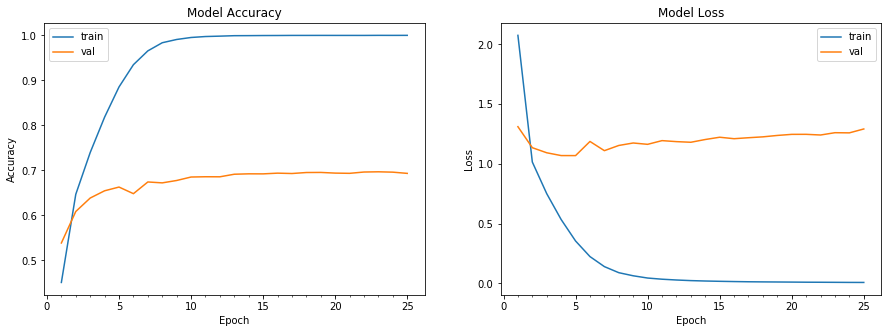

Accuracy on test data is: 69.32


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))